In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_CuoiKy'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS6_S7N_TranHoangBach/LDS6_TranHoangBach_CuoiKy


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [6]:
data = pd.read_excel('ItemList.xlsx', header=None)
data

,0,1,2,3,4,5,6,7,8,9,10
0,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14958,tropical fruit,berries,other vegetables,yogurt,kitchen towels,napkins,NaN,NaN,NaN,NaN,NaN
14959,bottled water,herbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14960,fruit/vegetable juice,onions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14961,soda,root vegetables,semi-finished bread,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
from mlxtend.preprocessing import TransactionEncoder

records = data.T.apply(lambda x: x.dropna().tolist()).tolist()
trans_enc = TransactionEncoder()
data_transformed = trans_enc.fit(records).transform(records)
df = pd.DataFrame(data_transformed, columns=trans_enc.columns_)
df

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,beverages,bottled beer,bottled water,brandy,brown bread,butter,butter milk,cake bar,candles,candy,canned beer,canned fish,canned fruit,canned vegetables,cat food,cereals,chewing gum,chicken,chocolate,chocolate marshmallow,citrus fruit,cleaner,cling film/bags,cocoa drinks,coffee,condensed milk,cooking chocolate,cookware,cream,cream cheese,...,salt,salty snack,sauces,sausage,seasonal products,semi-finished bread,shopping bags,skin care,sliced cheese,snack products,soap,soda,soft cheese,softener,soups,sparkling wine,specialty bar,specialty cheese,specialty chocolate,specialty fat,specialty vegetables,spices,spread cheese,sugar,sweet spreads,syrup,tea,tidbits,toilet cleaner,tropical fruit,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,F

Phân tích đề bài:
- Nhóm Association Rule learning có 2 thuật toán cơ bản là Apriori và ECLAT, mỗi thuật toán có ưu điểm và khuyết điểm riêng.
- Đối với data này, có đến gần 15.000 giao dịch, 167 items nên ưu tiên chọn Apriori vì Apriori hoạt động tốt số lượng data này. Đồng thời không quá lớn để Apriori chạy chậm.
- Vì Apriori yêu cầu có bộ nhớ đủ lớn để thực hiện nên bài này được chạy trên Google Colab để dễ dàng thực hiện.
- Đồng thời để tăng tốc quá trình tính toán, ta đặt thêm giá trị tối thiểu cho support và confidence.
- Với min_support = 0.002, ta có thể lựa chọn được các items và cặp/nhóm items kết hợp có ít nhất 30 giao dịch (trên tổng 15.000 giao dịch) là phù hợp


In [21]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(df, min_support=0.002, use_colnames=True).sort_values('support', ascending=False)
frequent_itemsets

,support,itemsets
123,0.157923,(whole milk)
78,0.122101,(other vegetables)
93,0.110005,(rolls/buns)
104,0.097106,(soda)
124,0.085879,(yogurt)
...,...,...
166,0.002005,"(butter, root vegetables)"
213,0.002005,"(root vegetables, domestic eggs)"
252,0.002005,"(newspapers, pastry)"
209,0.002005,"(rolls/buns, dessert)"


In [34]:
frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: 'sausage' in x)].head(1)

,support,itemsets
99,0.060349,(sausage)


- 'sausage' có Support khoảng 6%, tương đương với items 'sausage' có mặt trong hơn 900 giao dịch trong tổng cộng 15.000 giao dịch.
- Với bảng Frequent_itemsets tìm được ở trên, ta tiến hành tính toán confidence, lift, leverage, conviction. Và từ đó tìm antecedents là 'sausage' để xem các items kết hợp mua kèm với 'sausage' như thế nào.
- Chọn min_confidence = 0.05, có nghĩa là có ít nhất 5% trường hợp items consequents được mua chung nếu 'sausage' được mua.

In [37]:
from mlxtend.frequent_patterns import association_rules
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.05).sort_values('confidence', ascending=False)
rules_sausage = rules[rules['antecedents'].apply(lambda x: 'sausage' in x)]
rules_sausage

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,(sausage),(whole milk),0.060349,0.157923,0.008955,0.148394,0.939663,-0.000575,0.988811
34,(sausage),(other vegetables),0.060349,0.122101,0.006015,0.099668,0.816272,-0.001354,0.975083
36,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,0.000088,1.001613
39,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,0.000565,1.010345
47,(sausage),(rolls/buns),0.060349,0.110005,0.005347,0.088594,0.805362,-0.001292,0.976508
110,(sausage),(bottled beer),0.060349,0.045312,0.003342,0.055371,1.222000,0.000607,1.010649
112,(sausage),(root vegetables),0.060349,0.069572,0.003342,0.055371,0.795885,-0.000857,0.984967
115,(sausage),(pastry),0.060349,0.051728,0.003208,0.053156,1.027617,0.000086,1.001509
118,(sausage),(bottled water),0.060349,0.060683,0.003141,0.052049,0.857715,-0.000521,0.990892
125,(sausage),(tropical fruit),0.060349,0.067767,0.003074,0.050941,0.751711,-0.001015,0.982271


Nhận xét:
- items được mua với 'sausage' nhiều nhất là 'whole milk', với confidence = 0.148 (14.8% khả năng 'whole milk' được mua nếu mua 'sausage'), tuy nhiên lift sausage - whole milk < 1 nên mặc dù confidence cao nhưng 2 sản phẩm không có mối liên hệ nhiều lắm.
- sort lại theo lift để tìm kiếm mối liên hệ lớn nhất.

In [38]:
rules_sausage.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
110,(sausage),(bottled beer),0.060349,0.045312,0.003342,0.055371,1.222000,0.000607,1.010649
39,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,0.000565,1.010345
115,(sausage),(pastry),0.060349,0.051728,0.003208,0.053156,1.027617,0.000086,1.001509
36,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,0.000088,1.001613
13,(sausage),(whole milk),0.060349,0.157923,0.008955,0.148394,0.939663,-0.000575,0.988811
118,(sausage),(bottled water),0.060349,0.060683,0.003141,0.052049,0.857715,-0.000521,0.990892
34,(sausage),(other vegetables),0.060349,0.122101,0.006015,0.099668,0.816272,-0.001354,0.975083
47,(sausage),(rolls/buns),0.060349,0.110005,0.005347,0.088594,0.805362,-0.001292,0.976508
112,(sausage),(root vegetables),0.060349,0.069572,0.003342,0.055371,0.795885,-0.000857,0.984967
125,(sausage),(tropical fruit),0.060349,0.067767,0.003074,0.050941,0.751711,-0.001015,0.982271


Nhận xét:
- Bảng trên cho thấy items có mối liên hệ nhiều nhất với sausage là bottled beer, với lift cao nhất là 1.222. Điều này cũng đúng với thực tế khi người ta thường ăn xúc xích + uống bia.
- Một phát hiện cũng thú vị là người ta cũng hay mua/ăn sausage chung với yogurt
- Các sản phẩm còn lại có lift gần bằng 1 hay nhỏ hơn 1 đều ít có mối liên hệ với sausage hơn 2 items ở trên.

15 sản phẩm được mua nhiều nhất: Index(['whole milk', 'other vegetables', 'rolls/buns', 'soda', 'yogurt',
       'root vegetables', 'tropical fruit', 'bottled water', 'sausage',
       'citrus fruit', 'pastry', 'pip fruit', 'shopping bags', 'canned beer',
       'bottled beer'],
      dtype='object')


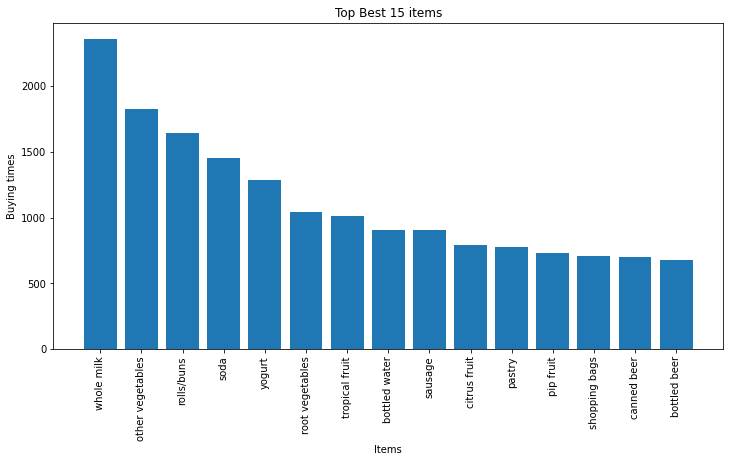

In [56]:
items_full = df.apply(pd.value_counts).iloc[1, :].sort_values(ascending=False)

# Top 15 sản phẩm được mua nhiều nhất
top_best_15_items = items_full[:15]
print('Top 15 sản phẩm được mua nhiều nhất: {}'.format(top_best_15_items.keys()))

x_ticks = np.arange(15)
plt.figure(figsize=(12,6))
plt.bar(x_ticks, top_best_15_items.values)
plt.xticks(x_ticks, top_best_15_items.keys(), rotation='vertical')
plt.xlabel('Items')
plt.ylabel('Buying times')
plt.title('Top Best 15 items')
plt.show()

Top 15 sản phẩm được mua ít nhất: Index(['specialty vegetables', 'organic products', 'liqueur', 'hair spray',
       'decalcifier', 'whisky', 'salad dressing', 'make up remover',
       'rubbing alcohol', 'toilet cleaner', 'frozen chicken', 'bags',
       'baby cosmetics', 'kitchen utensil', 'preservation products'],
      dtype='object')


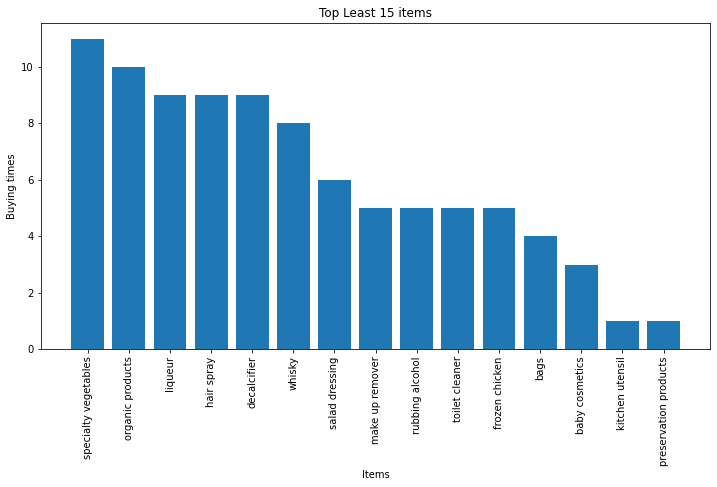

In [59]:
# Top 15 sản phẩm được mua ít nhất
top_least_15_items = items_full[-15:]
print('Top 15 sản phẩm được mua ít nhất: {}'.format(top_least_15_items.keys()))

x_ticks = np.arange(15)
plt.figure(figsize=(12,6))
plt.bar(x_ticks, top_least_15_items.values)
plt.xticks(x_ticks, top_least_15_items.keys(), rotation='vertical')
plt.xlabel('Items')
plt.ylabel('Buying times')
plt.title('Top Least 15 items')
plt.show()